In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import re
import pickle 
import time
import string
import emoji

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, fbeta_score, roc_curve, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier

import imblearn.over_sampling

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from gensim import matutils, models
import scipy.sparse

import nltk
from nltk import Text
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('punkt')

from sklearn.decomposition import TruncatedSVD, NMF

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.cluster import KMeans

from textblob import TextBlob

from wordcloud import WordCloud


# Extract data

In [2]:
# IRA tweets from 2012 to 2018
# function to loop through file names and append into one big DF
def get_data():
    name = "IRAhandle_tweets_{}.csv"
    
    dfs = []
    
    for num in range(1, 14):
        file_name = name.format(num)
        dfs.append(pd.read_csv(file_name, low_memory=False))
        
    return pd.concat(dfs)

rtt_df = get_data()

In [3]:
rtt_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2946207 entries, 0 to 20893
Data columns (total 21 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   external_author_id  object
 1   author              object
 2   content             object
 3   region              object
 4   language            object
 5   publish_date        object
 6   harvested_date      object
 7   following           int64 
 8   followers           int64 
 9   updates             int64 
 10  post_type           object
 11  account_type        object
 12  retweet             int64 
 13  account_category    object
 14  new_june_2018       int64 
 15  alt_external_id     object
 16  tweet_id            int64 
 17  article_url         object
 18  tco1_step1          object
 19  tco2_step1          object
 20  tco3_step1          object
dtypes: int64(6), object(15)
memory usage: 494.5+ MB


# Clean and Transform data

In [4]:
# get only needed columns
rtt_df = rtt_df[['publish_date', 'author', 'language', 'content', 'followers', 'account_category', 'retweet']]

In [5]:
# all data before cleaning
rtt_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2946207 entries, 0 to 20893
Data columns (total 7 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   publish_date      object
 1   author            object
 2   language          object
 3   content           object
 4   followers         int64 
 5   account_category  object
 6   retweet           int64 
dtypes: int64(2), object(5)
memory usage: 179.8+ MB


In [6]:
# remove the duplicates in DF
rtt_df.drop_duplicates(subset='content',inplace=True)

In [7]:
# make 'publish_date' a datetime type
rtt_df['publish_date'] = pd.to_datetime(rtt_df['publish_date'])

In [8]:
# DF after removing dupes
rtt_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2365553 entries, 0 to 20893
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   publish_date      datetime64[ns]
 1   author            object        
 2   language          object        
 3   content           object        
 4   followers         int64         
 5   account_category  object        
 6   retweet           int64         
dtypes: datetime64[ns](1), int64(2), object(4)
memory usage: 144.4+ MB


In [9]:
# pickle the rtt_df DF, pickled 8/24/2020
# rtt_df.to_pickle("rtt.pkl")

In [146]:
# load the pickled DF
rtt_df = pd.read_pickle("rtt.pkl")

In [147]:
# get only English language tweets
rtt_eng_df = rtt_df.loc[rtt_df['language'] == 'English']

In [148]:
# get DF shape after filtering for English tweets only
rtt_eng_df.shape

(1754406, 7)

In [149]:
# no retweets
rtt_eng_df = rtt_eng_df.loc[rtt_eng_df['retweet'] == 0]

In [150]:
# get DF shape after filtering for no retweets
rtt_eng_df.shape

(1185557, 7)

In [151]:
# get a count of unique account categories, eg Right Troll, Left Troll, Newsgroup, etc
rtt_df.account_category.nunique()

8

In [152]:
# get rid of URLs in 'contents' (the tweets)
rtt_eng_df['content'] = rtt_eng_df['content'].str.replace('http\S+|www.\S+', '', case=False)

In [153]:
# make 'contents' strings all lowercase
rtt_eng_df['content'] = rtt_eng_df['content'].str.lower()

In [154]:
# get rid of @ sign and any letters or numbers after it
rtt_eng_df['content'] = rtt_eng_df['content'].replace({r'\@[a-zA-Z0-9]*': ''}, regex=True)

In [155]:
# get rid of # sign and any letters or numbers after it
rtt_eng_df['content'] = rtt_eng_df['content'].replace({r'\#[a-zA-Z0-9]*': ''}, regex=True)

In [156]:
# replace any character in brackets [] with nothing
rtt_eng_df['content'] = rtt_eng_df['content'].replace({r'\[.*?\]': ''}, regex=True)

In [157]:
# replace punctuation with nothing
rtt_eng_df['content'] = rtt_eng_df['content'].replace({'[%s]' % re.escape(string.punctuation): ''}, regex=True)

In [158]:
# replace weird double-quotes (“ ”), single-quotes (’) and (…) with nothing
rtt_eng_df['content'] = rtt_eng_df['content'].replace({r'[‘’“”…]': ''}, regex=True)

In [159]:
# replace digits surrounded by text with nothing
rtt_eng_df['content'] = rtt_eng_df['content'].replace({'\w*\d\w*': ''}, regex=True)

In [160]:
# remove words of length 1
rtt_eng_df['content'] = rtt_eng_df['content'].replace({r'\W*\b\w{1}\b': ''}, regex=True)

In [161]:
# function to define emojis and symbols to remove

def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)


In [162]:
# remove emojis and weird symbols by calling the above function 'remove_emoji'
rtt_eng_df['content'] = rtt_eng_df['content'].astype(str).apply(remove_emoji)

In [163]:
# reset the DF index before pickling
rtt_eng_df.reset_index(inplace=True)
rtt_eng_df.drop(columns=['index'], inplace=True)

In [164]:
# pickle rtt_eng_df, pickled 8/24/2020
rtt_eng_df.to_pickle("rtt_eng_df.pkl")

In [2]:
# load the pickled rtt_eng_df 
#rtt_eng_df = pd.read_pickle("rtt_eng_df.pkl")

In [165]:
# filter for only Right Troll and Left Troll data
rtt_right_left_df = rtt_eng_df.loc[(rtt_eng_df['account_category'] == 'RightTroll') | 
                                  (rtt_eng_df['account_category'] == 'LeftTroll')].copy()

In [166]:
# get a count of the total Right and Left Troll tweets
rtt_right_left_df.account_category.value_counts()

RightTroll    371762
LeftTroll      65232
Name: account_category, dtype: int64

In [167]:
# check for missing data
rtt_right_left_df.isnull().sum()

publish_date        0
author              0
language            0
content             0
followers           0
account_category    0
retweet             0
dtype: int64

In [168]:
# filter for data from 3/1/17 to 9/1/17
start_date = '2017-03-01'
end_date = '2017-9-01'

mask = (rtt_right_left_df['publish_date'] >= start_date) & (rtt_right_left_df['publish_date'] <= end_date)

rtt_small_df = rtt_right_left_df.loc[mask]

In [169]:
# get the number of tweets to analyze
rtt_small_df.shape

(204510, 7)

In [175]:
rtt_small_df.head()

,publish_date,author,language,content,followers,account_category,retweet
4590,2017-07-23 22:47:00,ABBYLOPTRT,English,newt explains how scaramucci will change the w...,0,RightTroll,0
4591,2017-07-23 22:47:00,ABBYLOPTRT,English,schumer shockingly admits who is really to bla...,0,RightTroll,0
4592,2017-07-23 22:47:00,ABBYLOPTRT,English,hungarys pm just called out soros in chilling ...,0,RightTroll,0
5531,2017-08-11 13:02:00,ABIISSROSB,English,muslim terror group defends mcmaster,487,RightTroll,0
5532,2017-08-11 13:02:00,ABIISSROSB,English,fox news host slams mueller for stacking the ...,487,RightTroll,0


In [176]:
# subset to Right Trolls only
rtt_eng_right_df = rtt_small_df.loc[rtt_small_df['account_category'] == 'RightTroll'].copy()
rtt_eng_right_df.reset_index(inplace=True)
rtt_eng_right_df.drop(columns=['index'], inplace=True)

In [178]:
# get list of authors with 20 or more tweets to create the mask below
author_lst = []

val_cnts = rtt_eng_right_df.author.value_counts()

for i in range(0, len(val_cnts)):
    if val_cnts[i] >= 20:
        author_lst.append(val_cnts.index[i])


161

In [356]:
rtt_eng_right_df.author.value_counts().head(20)

WORLDNEWSPOLI     17772
DEBESSTRS         10397
ELIZEESTR          8482
ADNNELSTR          6023
LAWWAANCTR         5921
CHAASNTR           5362
MAYLUUSSTR         4689
MARRISSATRR        4643
ELINSSTR           3749
EISSYT56T          3437
DANISSTRS          3298
LILAASTRS          3297
CELLSSTITR         3232
PAMELA_MOORE13     2929
TEN_GOP            2848
EVANNGHARTR        2824
AMBERLINETR        2812
ALEXXDRTRR         2728
ANIIANTRS          2559
THELMMISB          2416
Name: author, dtype: int64

In [355]:
# mask for authors with more than 20 tweets
mask = rtt_eng_right_df['author'].apply(lambda x: True if x in author_lst else False)

# use only authors with more than 20 tweets
rtt_eng_right_df = rtt_eng_right_df.loc[mask]

In [180]:
# get shape of Right Troll DF after filtering for authors with 20 or more tweets
rtt_eng_right_df.shape

(190792, 7)

In [181]:
# get number of unique authors with 20 or more tweets
rtt_eng_right_df.author.nunique()

161

In [182]:
# subset to Left Trolls only
rtt_eng_left_df = rtt_small_df.loc[rtt_small_df['account_category'] == 'LeftTroll'].copy()
rtt_eng_left_df.reset_index(inplace=True)
rtt_eng_left_df.drop(columns=['index'], inplace=True)

In [183]:
# get shape of Left Troll DF
rtt_eng_left_df.shape

(13346, 7)

# EDA

## Stop Words

In [184]:
# STOP WORDS list
additional  = ['rt','rts','retweet', 'via', 'amp', 'app', 'im', 'says', 'lol', "'d", "'ll", "'re", "'s", "'ve",
               'abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', "n't", 'need',
               'onc', 'onli', 'ourselv', 'say', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would',
               'yourselv', 'becau', '–', 'back', 'call', 'u', 'get']
swords = set().union(stopwords.words('english'), additional)

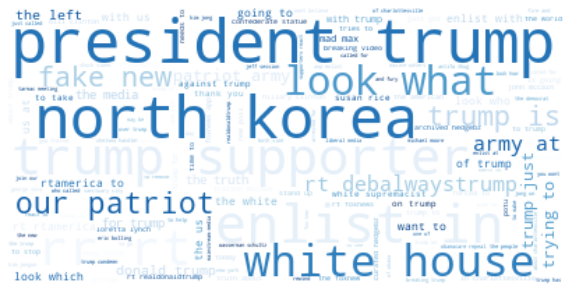

In [185]:
# create DF of one big string for the corpus
right_corpus_df = pd.DataFrame(' '.join(rtt_eng_right_df['content'].tolist()), columns=['content'], index=[0])
right_corpus_df.content = right_corpus_df.content.astype(str)

# make a Word Cloud of all tweets
wc = WordCloud(stopwords=swords, background_color="white", colormap="Blues",
               max_font_size=150, random_state=42).generate(' '.join(right_corpus_df['content']))

# set plot dimensions
plt.rcParams['figure.figsize'] = [10, 20]

# Create word count plot for entire Right Troll corpus
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
#plt.title('Corpus Word Count')
    
plt.show()

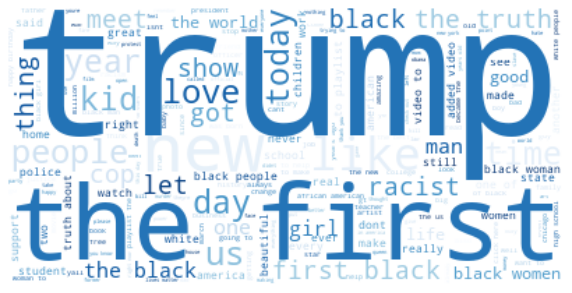

In [186]:
# create DF of one big string for the corpus
left_corpus_df = pd.DataFrame(' '.join(rtt_eng_left_df['content'].tolist()), columns=['content'], index=[0])
left_corpus_df.content = left_corpus_df.content.astype(str)

# make a Word Cloud of all tweets
wc = WordCloud(stopwords=swords, background_color="white", colormap="Blues",
               max_font_size=150, random_state=42).generate(' '.join(left_corpus_df['content']))

# set plot dimensions
plt.rcParams['figure.figsize'] = [10, 20]

# Create word count plot for entire Left Troll corpus
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
#plt.title('Corpus Word Count')
    
plt.show()

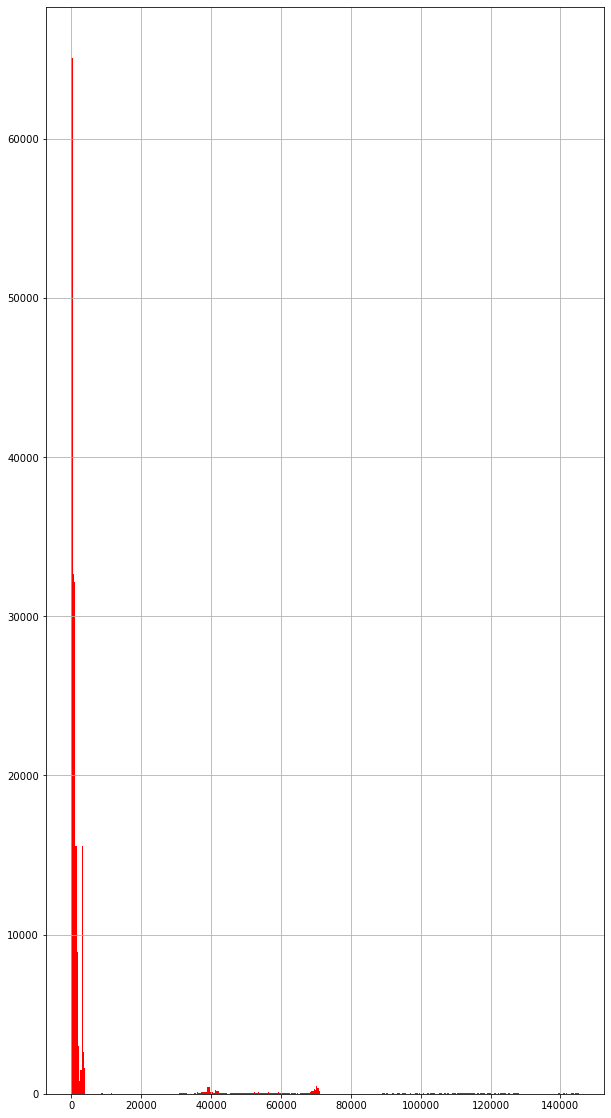

In [187]:
# histogram of counts of number of Right Troll tweet author followers
rtt_eng_right_df.followers.hist(color='red', bins=400);

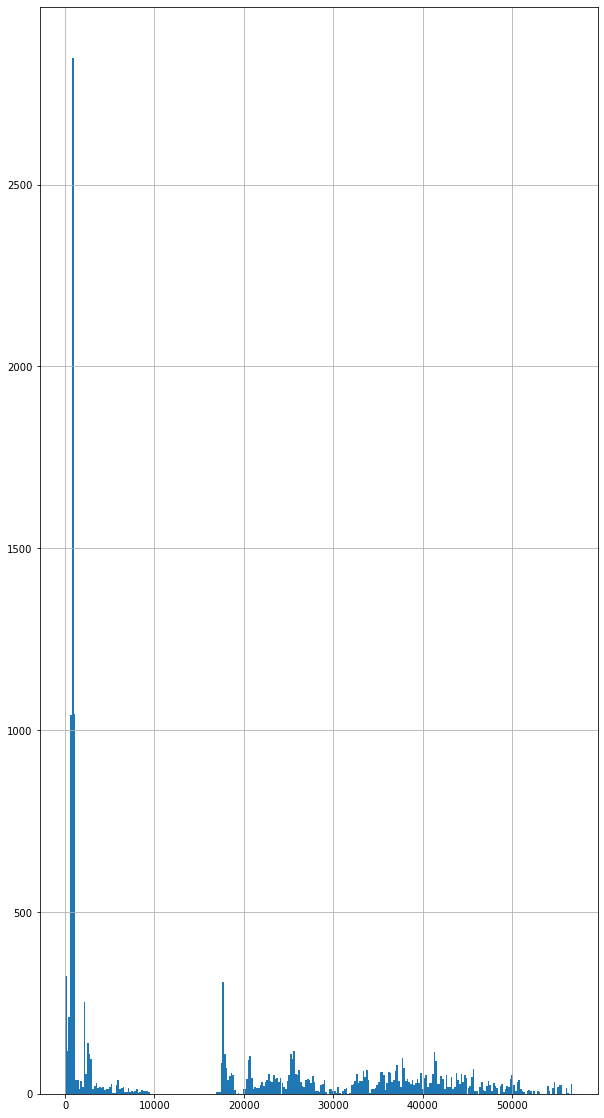

In [188]:
# histogram of counts of number of Left Troll tweet author followers
rtt_eng_left_df.followers.hist(bins=300);

In [190]:
# make each authors set of tweets a document
rtt_eng_right_agg_df = rtt_eng_right_df.groupby(['author'])['content'].apply(' '.join).reset_index()

In [366]:
rtt_eng_right_agg_df.index[126]

'LAWWAANCTR'

In [367]:
# display contents of first author's document
print(len(rtt_eng_right_agg_df.content[160]))
print(len(rtt_eng_right_agg_df.content[3]))
print(len(rtt_eng_right_agg_df.content[93]))
print(len(rtt_eng_right_agg_df.content[100]))
print(len(rtt_eng_right_agg_df.content[126]))

1204435
550074
1009201
732945
510996


In [192]:
# look at DF
rtt_eng_right_agg_df.head()

,author,content
0,ABIISSROSB,muslim terror group defends mcmaster fox ...
1,ABMERRLINS,schumer throws hillary under the bus but accid...
2,ACAPARELLA,democrat declares nra national security threa...
3,ADNNELSTR,thats right everything looted except work boot...
4,ADRIASNSS,rt obama now living just miles away from the...


In [193]:
# set the index of DF as the author names
rtt_eng_right_agg_df.set_index('author', inplace=True)

In [194]:
# look at DF
rtt_eng_right_agg_df.head()

,content
author,
ABIISSROSB,muslim terror group defends mcmaster fox ...
ABMERRLINS,schumer throws hillary under the bus but accid...
ACAPARELLA,democrat declares nra national security threa...
ADNNELSTR,thats right everything looted except work boot...
ADRIASNSS,rt obama now living just miles away from the...


# Sentiment Analysis

In [195]:
# lambda functions to find the polarity and subjectivity of each right troll
from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

rtt_eng_right_agg_df['polarity'] = rtt_eng_right_agg_df['content'].apply(pol)
rtt_eng_right_agg_df['subjectivity'] = rtt_eng_right_agg_df['content'].apply(sub)
rtt_eng_right_agg_df

,content,polarity,subjectivity
author,,,
ABIISSROSB,muslim terror group defends mcmaster fox ...,-0.015759,0.505488
ABMERRLINS,schumer throws hillary under the bus but accid...,0.016533,0.525464
ACAPARELLA,democrat declares nra national security threa...,-0.029639,0.519950
ADNNELSTR,thats right everything looted except work boot...,0.026401,0.469951
ADRIASNSS,rt obama now living just miles away from the...,0.010331,0.485221
...,...,...,...
THELMMISB,bitter michelle obama comes out of hiding imm...,0.021283,0.506059
USA_GUNSLINGER,enjoy your million dollar homes while the maj...,0.060436,0.499001
VEROSANRRT,lol transgendered navy seal challenges trump...,0.036762,0.491681


In [196]:
rtt_eng_right_agg_df.reset_index(inplace=True)
rtt_eng_right_agg_df['author_name'] = rtt_eng_right_agg_df['author']
rtt_eng_right_agg_df.set_index('author', inplace=True)
rtt_eng_right_agg_df.tail(50)

,content,polarity,subjectivity,author_name
author,,,,
HYDDROX,thank you ofrights for recommending this book ...,0.098700,0.489947,HYDDROX
IMOGEENTR,unholy alliance north korea and iran forming...,0.008715,0.505340,IMOGEENTR
INTERFISCHER,wtf taxpayer funded cuny instructing profes...,0.063950,0.475764,INTERFISCHER
IVAASSNTR,rt lets show our support for our president i...,-0.004320,0.521314,IVAASSNTR
JANSKEESTR,this is how democrats have weaponized fake ne...,0.016661,0.510504,JANSKEESTR
JEANNEMCCARTHY0,uk muslima shot by police as they foil active ...,0.058053,0.440330,JEANNEMCCARTHY0
JEFFREYKAHUNAS,mt there is no system of taxation so immune t...,0.136329,0.475066,JEFFREYKAHUNAS
JENN_ABRAMS,speaking about soda tax lego set to honor wom...,0.121931,0.499622,JENN_ABRAMS
JOHAAJOTS,look who trump will donate his quarter salar...,-0.008858,0.529779,JOHAAJOTS


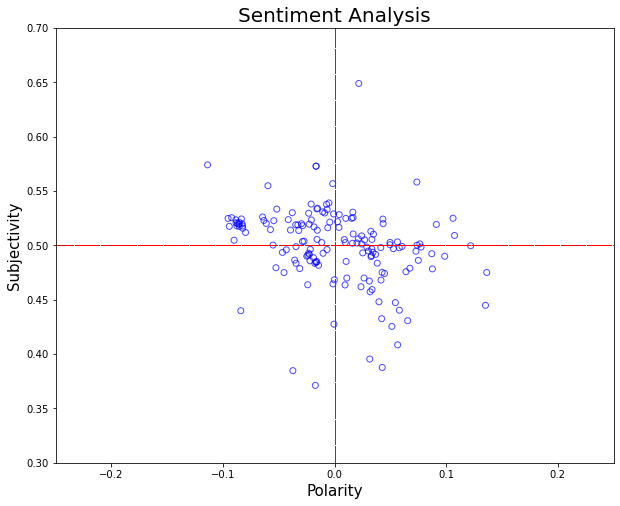

In [200]:
# plot the Sentiment Analysis results

plt.rcParams['figure.figsize'] = [10, 8]

for index, author in enumerate(rtt_eng_right_agg_df.index):
    x = rtt_eng_right_agg_df.polarity.loc[author]
    y = rtt_eng_right_agg_df.subjectivity.loc[author]
    plt.scatter(x, y, facecolors='none', edgecolors='blue', alpha=.7)
    plt.xlim(-.25, .25)
    plt.ylim(.3, .7)
    plt.axhline(y=0.5, color='r', linestyle='dashed', linewidth=.7)
    plt.axvline(x=0, color='r', linestyle='dashed', linewidth=.7)
    
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('Polarity', fontsize=15)
plt.ylabel('Subjectivity', fontsize=15)

plt.show()

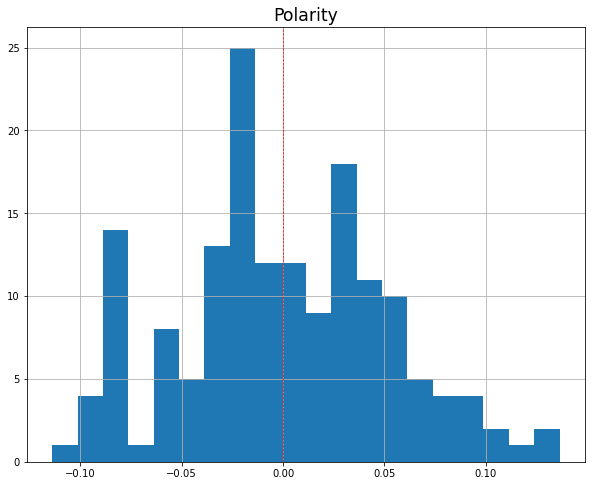

In [201]:
# histogram of polarity
rtt_eng_right_agg_df['polarity'].hist(bins=20)
plt.axvline(x=0, color='r', linestyle='dashed', linewidth=.7)
plt.title('Polarity', ha='center', fontsize='xx-large');

In [202]:
sum(rtt_eng_right_agg_df['polarity'] > 0)

75

In [203]:
sum(rtt_eng_right_agg_df['polarity'] <= 0)

86

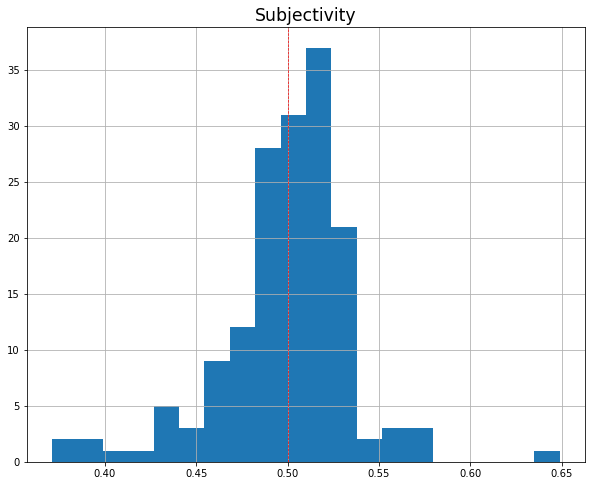

In [204]:
# histogram of polarity
rtt_eng_right_agg_df['subjectivity'].hist(bins=20)
plt.axvline(x=0.5, color='r', linestyle='dashed', linewidth=.7)
plt.title('Subjectivity', ha='center', fontsize='xx-large');

In [205]:
sum(rtt_eng_right_agg_df['subjectivity'] > .5)

88

In [206]:
sum(rtt_eng_right_agg_df['subjectivity'] <= .5)

73

## Lemmatizer

In [207]:
# function to lemmatize the author docs
def tokenized_lem(text):
    tokens = nltk.word_tokenize(text)
    lem = []

    for item in tokens:
        lem.append(WordNetLemmatizer().lemmatize(item))

    return lem

# Vectorization

## CountVectorizer

In [208]:
# vectorize, tokenize, filter for stopwords and create 1 and 2 ngrams
cnt_vec = CountVectorizer(tokenizer = tokenized_lem, ngram_range=(1, 2), stop_words=swords, min_df=0.1)

# fit and transform document to Count Vectorizer
right_cv = cnt_vec.fit_transform(rtt_eng_right_agg_df.content)

# make right_cv fit into Document-Term Matrix DF
dtm_right_df = pd.DataFrame(right_cv.toarray(), columns=cnt_vec.get_feature_names())

# assign the DF the author's names as index
dtm_right_df.index = rtt_eng_right_agg_df.index


In [209]:
# pickle the vectorizer
pickle.dump(cnt_vec, open("my_pickled_vectorizer.p", "wb"))

In [210]:
# look at shape of DTM
dtm_right_df.shape

(161, 13111)

In [211]:
# get names of DTM feature for later use
cnt_vec_cols = cnt_vec.get_feature_names()

# make into a DF
cnt_vec_cols_df = pd.DataFrame(cnt_vec_cols, columns=['terms'])

In [212]:
# look at count vector rows to make sure they match the DTM columns
cnt_vec_cols_df.shape

(13111, 1)

In [213]:
# transpose DTM for creating top words by author dictionary
dtm_right_tran_df = dtm_right_df.transpose()

In [214]:
# Find the top 30 words for each author
top_dict = {}

for c in dtm_right_tran_df.columns:
    top = dtm_right_tran_df[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

{'ABIISSROSB': [('trump', 158),
  ('breaking', 61),
  ('charlottesville', 48),
  ('look', 47),
  ('antifa', 39),
  ('video', 38),
  ('liberal', 37),
  ('korea', 30),
  ('new', 29),
  ('north', 25),
  ('medium', 23),
  ('potus', 21),
  ('statue', 21),
  ('obama', 20),
  ('north korea', 20),
  ('news', 20),
  ('watch', 19),
  ('like', 17),
  ('white', 17),
  ('time', 16),
  ('called', 15),
  ('realdonaldtrump', 15),
  ('report', 15),
  ('zero', 15),
  ('hedge', 14),
  ('one', 14),
  ('zero hedge', 14),
  ('senator', 13),
  ('maxinewaters', 13),
  ('washingtonpost', 13)],
 'ABMERRLINS': [('trump', 169),
  ('breaking', 81),
  ('traitor', 43),
  ('video', 38),
  ('look', 35),
  ('new', 31),
  ('house', 26),
  ('obamacare', 24),
  ('gop', 23),
  ('mccain', 22),
  ('obama', 20),
  ('news', 20),
  ('white', 20),
  ('dem', 20),
  ('president', 19),
  ('liberal', 19),
  ('white house', 18),
  ('wow', 18),
  ('watch', 17),
  ('fake', 17),
  ('american', 16),
  ('ban', 16),
  ('viral', 15),
  ('re

In [215]:
# Print the top 15 words tweeted by each author
for author, top_words in top_dict.items():
    print(author)
    print(', '.join([word for word, count in top_words[0:15]]))
    print('---')

ABIISSROSB
trump, breaking, charlottesville, look, antifa, video, liberal, korea, new, north, medium, potus, statue, obama, north korea
---
ABMERRLINS
trump, breaking, traitor, video, look, new, house, obamacare, gop, mccain, obama, news, white, dem, president
---
ACAPARELLA
trump, breaking, charlottesville, look, antifa, video, korea, liberal, medium, new, obama, statue, president, north, north korea
---
ADNNELSTR
enlist, patriot, army, join, stand, america, freedom, people, read, truth, usfreedomarmy, gt, msm, fight, socialist
---
ADRIASNSS
trump, potus, realdonaldtrump, korea, president, north, liberal, american, kim, north korea, president trump, threat, carrieksada, obama, one
---
AFEELIUTR
trump, breaking, look, video, new, liberal, charlottesville, traitor, obama, korea, watch, antifa, white, potus, gop
---
ALANISSTRS
trump, potus, foxnews, want, president, korea, people, realdonaldtrump, white, north, walk, north korea, dead, dloesch, cop
---
ALAXXATR
trump, obama, breaking, po

## TF-IDF

In [216]:
# vectorize, tokenize, filter for stopwords and create 1 and 2 ngrams
tfidf_vec = TfidfVectorizer(tokenizer = tokenized_lem, ngram_range=(1, 2), stop_words=swords, min_df=0.1)

# fit and transform document to TF-IDF Vectorizer
right_tfidf = tfidf_vec.fit_transform(rtt_eng_right_agg_df.content)


In [217]:
# make right_tfidf fit into a DF
dtm_right_tdidf_df = pd.DataFrame(right_tfidf.toarray(), columns=tfidf_vec.get_feature_names())

dtm_right_tdidf_df.index = rtt_eng_right_agg_df.index

In [218]:
# get names of DTM feature for later use
tfidf_vec_cols = tfidf_vec.get_feature_names()

# make into a DF
tfidf_vec_cols_df = pd.DataFrame(tfidf_vec_cols, columns=['terms'])

In [219]:
# make sure rows match DTM cols
tfidf_vec_cols_df.shape

(13111, 1)

In [220]:
# transpose DTM for creating top words by author dictionary
dtm_right_tdidf_tran_df = dtm_right_tdidf_df.transpose()

In [221]:
# Find the top 30 words for each author
top_dict = {}

for c in dtm_right_tdidf_tran_df.columns:
    top = dtm_right_tdidf_tran_df[c].sort_values(ascending=False).head(30)
    top_dict[c]= list(zip(top.index, top.values))

top_dict

{'ABIISSROSB': [('trump', 0.5010980465370054),
  ('breaking', 0.21094777666953776),
  ('charlottesville', 0.2043968844204397),
  ('look', 0.16152975254339239),
  ('antifa', 0.14262827810973083),
  ('zero hedge', 0.141960264940544),
  ('hedge', 0.12918686656452966),
  ('video', 0.1250656123054765),
  ('liberal', 0.1232885716361237),
  ('washingtonpost', 0.11995923323849182),
  ('maxinewaters', 0.10440354824779105),
  ('korea', 0.1043898628635458),
  ('zero', 0.09726432335410676),
  ('new', 0.09485711606819404),
  ('potus', 0.09360627989321119),
  ('north', 0.08753276722212792),
  ('statue', 0.08714643599875416),
  ('realdonaldtrump', 0.08113838403632001),
  ('medium', 0.07855854873370119),
  ('north korea', 0.07090112602779969),
  ('obama', 0.06623191870213647),
  ('watch', 0.066113579813579),
  ('news', 0.06501596838392674),
  ('like', 0.05915425562267594),
  ('called', 0.05731520189768506),
  ('white', 0.05699734349962706),
  ('time', 0.054312253826158674),
  ('report', 0.053841206406

In [222]:
# Print the top 15 words tweeted by each author
for author, top_words in top_dict.items():
    print(author)
    print(', '.join([word for word, count in top_words[0:15]]))
    print('---')

ABIISSROSB
trump, breaking, charlottesville, look, antifa, zero hedge, hedge, video, liberal, washingtonpost, maxinewaters, korea, zero, new, potus
---
ABMERRLINS
trump, breaking, traitor, video, look, new, house, obamacare, mccain, gop, dem, wassermanschultz, wow, transgender, white
---
ACAPARELLA
trump, breaking, charlottesville, antifa, look, video, korea, liberal, statue, medium, new, obama, nytimes, vp, north
---
ADNNELSTR
enlist, patriot, army, join, usfreedomarmy, stand, freedom, gt, america, marxist, read, socialist, people, msm, truth
---
ADRIASNSS
trump, realdonaldtrump, potus, carrieksada, repkathleenrice, korea, kim, justanavywife, north, president, securefreedom, liberal, american, north korea, base
---
AFEELIUTR
trump, breaking, look, video, mycalynn, ravennightmyst, charlottesville, traitor, new, liberal, potus, jbwredsox, korea, obama, senjohnmccain
---
ALANISSTRS
trump, foxnews, potus, dloesch, okay, realdonaldtrump, mitchellvii, gartrelllinda, walk, repkathleenrice, w

# Topic Modeling

## CountVectorizer

In [223]:
# Transpose dtm (Doc-Term) to tdm (Term-Doc) matrix
tdm_right_df = dtm_right_df.transpose()

In [224]:
# look at transpose TDM
tdm_right_df.head()

author,ABIISSROSB,ABMERRLINS,ACAPARELLA,ADNNELSTR,ADRIASNSS,AFEELIUTR,ALANISSTRS,ALAXXATR,ALDRICH420,ALESSIAWILLSON,...,SECRETREPORTT,SOUTHLONESTAR,SOUTHLONESTAR2,TEN_GOP,THEFOUNDINGSON,THELMMISB,USA_GUNSLINGER,VEROSANRRT,WADEHARRIOT,WORLDNEWSPOLI
abandon,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,6
abandoned,0,0,0,0,0,0,0,0,0,0,...,0,0,0,3,0,0,0,0,0,4
abbot,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
abbot praise,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
abbott,2,1,1,1,0,3,0,2,0,0,...,0,2,0,0,0,3,0,1,0,15


In [225]:
# put the term-document matrix into gensim format, from df to sparse matrix to gensim corpus
sparse_cnts = scipy.sparse.csr_matrix(tdm_right_df)
corpus = matutils.Sparse2Corpus(sparse_cnts)

In [226]:
# Gensim requires dictionary of the all terms and their location in the term-document matrix
id2word = dict((v, k) for k, v in cnt_vec.vocabulary_.items())

### Display Topics fcn

In [227]:
# fcn to display topics of factorization
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

## LDA

In [228]:
# LDA (Latent Dirichlet Allocation), number of topics=2
lda2 = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=2, passes=10)
lda2.print_topics()

[(0,
  '0.023*"trump" + 0.008*"breaking" + 0.007*"enlist" + 0.006*"video" + 0.005*"patriot" + 0.005*"liberal" + 0.004*"new" + 0.004*"president" + 0.003*"army" + 0.003*"obama"'),
 (1,
  '0.021*"trump" + 0.006*"breaking" + 0.004*"potus" + 0.004*"obama" + 0.004*"look" + 0.004*"realdonaldtrump" + 0.004*"charlottesville" + 0.004*"antifa" + 0.004*"liberal" + 0.003*"medium"')]

In [229]:
# LDA (Latent Dirichlet Allocation), number of topics=3
lda3 = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=3, passes=10)
lda3.print_topics()

[(0,
  '0.021*"trump" + 0.006*"enlist" + 0.005*"breaking" + 0.005*"video" + 0.005*"president" + 0.004*"patriot" + 0.004*"new" + 0.004*"people" + 0.004*"america" + 0.004*"obama"'),
 (1,
  '0.023*"trump" + 0.008*"breaking" + 0.005*"look" + 0.005*"charlottesville" + 0.004*"video" + 0.004*"liberal" + 0.004*"antifa" + 0.004*"obama" + 0.003*"potus" + 0.003*"korea"'),
 (2,
  '0.021*"trump" + 0.008*"breaking" + 0.007*"congress" + 0.006*"antifa" + 0.006*"mueller" + 0.006*"american" + 0.005*"liberal" + 0.005*"obama" + 0.005*"medium" + 0.005*"look"')]

In [230]:
# LDA (Latent Dirichlet Allocation), number of topics=4
lda4 = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=4, passes=10)
lda4.print_topics()

[(0,
  '0.023*"trump" + 0.009*"breaking" + 0.005*"look" + 0.005*"video" + 0.005*"charlottesville" + 0.004*"liberal" + 0.004*"antifa" + 0.003*"obama" + 0.003*"korea" + 0.003*"new"'),
 (1,
  '0.028*"trump" + 0.008*"video" + 0.008*"breaking" + 0.005*"new" + 0.005*"president" + 0.004*"obama" + 0.004*"liberal" + 0.004*"comey" + 0.004*"house" + 0.003*"news"'),
 (2,
  '0.027*"enlist" + 0.016*"trump" + 0.015*"patriot" + 0.012*"army" + 0.009*"breaking" + 0.007*"liberal" + 0.006*"join" + 0.006*"look" + 0.006*"stand" + 0.005*"america"'),
 (3,
  '0.018*"trump" + 0.006*"potus" + 0.006*"realdonaldtrump" + 0.005*"american" + 0.005*"obama" + 0.005*"president" + 0.004*"america" + 0.004*"medium" + 0.004*"democrat" + 0.004*"people"')]

In [231]:
# LDA (Latent Dirichlet Allocation), number of topics=5
lda5 = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=5, passes=10)
lda5.print_topics()

[(0,
  '0.030*"trump" + 0.012*"breaking" + 0.010*"video" + 0.006*"liberal" + 0.005*"new" + 0.004*"comey" + 0.004*"president" + 0.003*"obama" + 0.003*"house" + 0.003*"look"'),
 (1,
  '0.019*"trump" + 0.010*"remember" + 0.006*"new" + 0.006*"president" + 0.004*"president trump" + 0.003*"make" + 0.003*"video" + 0.003*"house" + 0.003*"obama" + 0.003*"korea"'),
 (2,
  '0.015*"enlist" + 0.013*"trump" + 0.010*"patriot" + 0.007*"army" + 0.007*"america" + 0.006*"people" + 0.006*"american" + 0.005*"congress" + 0.005*"democrat" + 0.005*"obama"'),
 (3,
  '0.023*"trump" + 0.009*"breaking" + 0.005*"look" + 0.005*"video" + 0.005*"charlottesville" + 0.004*"liberal" + 0.004*"antifa" + 0.003*"korea" + 0.003*"obama" + 0.003*"new"'),
 (4,
  '0.020*"trump" + 0.007*"potus" + 0.007*"realdonaldtrump" + 0.005*"president" + 0.004*"obama" + 0.004*"breaking" + 0.003*"white" + 0.003*"medium" + 0.003*"foxnews" + 0.003*"people"')]

## LSA

In [232]:
# Latent Semantic Analysis (LSA), 2 components
lsa2 = TruncatedSVD(2)
right_topic = lsa2.fit_transform(right_cv)
lsa2.explained_variance_ratio_

array([0.50320304, 0.3088867 ])

In [233]:
# X matrix for classification
right_topic.shape

(161, 2)

In [234]:
# Top 10 terms for the 2 Topics LSA model
display_topics(lsa2, cnt_vec.get_feature_names(), 10)


Topic  0
trump, breaking, video, obama, new, american, president, democrat, medium, congress

Topic  1
enlist, patriot, army, join, stand, america, freedom, people, read, usfreedomarmy


In [235]:
# Latent Semantic Analysis (LSA), 3 components
lsa3 = TruncatedSVD(3)
right_topic = lsa3.fit_transform(right_cv)
lsa3.explained_variance_ratio_

array([0.50320304, 0.3088867 , 0.10263238])

In [236]:
# Top 10 terms for the 3 Topics LSA model
display_topics(lsa3, cnt_vec.get_feature_names(), 10)


Topic  0
trump, breaking, video, obama, new, american, president, democrat, medium, congress

Topic  1
enlist, patriot, army, join, stand, america, freedom, people, read, usfreedomarmy

Topic  2
congress, mueller, american, democrat, fbi, russia, antifa, doj, realdonaldtrump, soros


In [237]:
# Latent Semantic Analysis (LSA), 4 components
lsa4 = TruncatedSVD(4)
right_topic = lsa4.fit_transform(right_cv)
lsa4.explained_variance_ratio_

array([0.50320304, 0.3088867 , 0.10263238, 0.0317904 ])

In [238]:
# Top 10 terms for the 4 Topics LSA model
display_topics(lsa4, cnt_vec.get_feature_names(), 10)


Topic  0
trump, breaking, video, obama, new, american, president, democrat, medium, congress

Topic  1
enlist, patriot, army, join, stand, america, freedom, people, read, usfreedomarmy

Topic  2
congress, mueller, american, democrat, fbi, russia, antifa, doj, realdonaldtrump, soros

Topic  3
potus, foxnews, realdonaldtrump, dont, like, charlottesville, president, people, look, good


In [239]:
# Latent Semantic Analysis (LSA), 5 components
lsa5 = TruncatedSVD(5)
right_topic = lsa5.fit_transform(right_cv)
lsa5.explained_variance_ratio_

array([0.50320304, 0.3088867 , 0.10263238, 0.0317904 , 0.00998198])

In [240]:
# Top 10 terms for the 5 Topics LSA model
display_topics(lsa5, cnt_vec.get_feature_names(), 10)


Topic  0
trump, breaking, video, obama, new, american, president, democrat, medium, congress

Topic  1
enlist, patriot, army, join, stand, america, freedom, people, read, usfreedomarmy

Topic  2
congress, mueller, american, democrat, fbi, russia, antifa, doj, realdonaldtrump, soros

Topic  3
potus, foxnews, realdonaldtrump, dont, like, charlottesville, president, people, look, good

Topic  4
foxnews, remember, president, donald, day, donald trump, people, woman, first, dont


## NMF

In [242]:
# Non-Negative Matrix Factorization (NMF), 2 components
nmf_model2 = NMF(2)
right_topic2 = nmf_model2.fit_transform(right_cv)

# Top 10 terms for the 2 Topics NMF model
print('2 Topics NMF model')
display_topics(nmf_model2, cnt_vec.get_feature_names(), 10)

2 Topics NMF model

Topic  0
trump, breaking, video, obama, new, american, president, democrat, medium, congress

Topic  1
enlist, patriot, army, join, stand, america, people, freedom, read, truth


In [243]:
# Non-Negative Matrix Factorization (NMF), 3 components
nmf_model3 = NMF(3)
right_topic3 = nmf_model3.fit_transform(right_cv)

# Top 10 terms for the 3 Topics NMF model
print('3 Topics NMF model')
display_topics(nmf_model3, cnt_vec.get_feature_names(), 10)

3 Topics NMF model

Topic  0
trump, breaking, video, new, president, liberal, obama, house, white, news

Topic  1
enlist, patriot, army, join, stand, america, people, freedom, read, truth

Topic  2
trump, congress, mueller, american, democrat, obama, medium, russia, fbi, antifa


In [244]:
# Non-Negative Matrix Factorization (NMF), 4 components
nmf_model4 = NMF(n_components=4, max_iter=1000)
right_topic4 = nmf_model4.fit_transform(right_cv)

# Top 10 terms for the 4 Topics NMF model
print('4 Topics NMF model')
display_topics(nmf_model4, cnt_vec.get_feature_names(), 10)

4 Topics NMF model

Topic  0
trump, breaking, video, new, obama, house, president, donald, donald trump, liberal

Topic  1
enlist, patriot, army, join, stand, america, freedom, people, read, truth

Topic  2
trump, congress, mueller, american, democrat, russia, obama, medium, fbi, fake

Topic  3
trump, potus, realdonaldtrump, foxnews, president, people, liberal, obama, look, like


In [314]:
df = pd.DataFrame(right_topic4)

In [315]:
df.head()

,0,1,2,3
0,1.441947,0.0000,0.000000,1.986408
1,2.172849,0.0000,0.132675,0.518779
2,1.465482,0.0000,0.000000,1.588436
3,0.022074,78.3375,0.000000,0.000000
4,0.300700,0.0000,0.007054,1.369014


In [317]:
df['authors'] = authors

In [323]:
df.sort_values(by=0, ascending=False)

,0,1,2,3,authors
160,65.553206,0.391838,0.000000,0.000000,WORLDNEWSPOLI
97,14.506039,0.000000,0.899329,1.352780,EISSYT56T
130,5.854625,0.000000,0.591893,0.000000,LUCYTRUMPTTOP56
25,5.731624,0.000000,0.589028,0.000000,ANDIOSMARRTRUMP
82,5.477571,0.000000,0.000000,11.928341,CHAASNTR
...,...,...,...,...,...
153,0.000000,0.009144,0.017462,0.212566,SOUTHLONESTAR2
155,0.000000,0.331593,0.188811,4.410260,THEFOUNDINGSON
10,0.000000,0.000000,1.147706,15.394277,ALEXXDRTRR
20,0.000000,0.000000,0.467784,9.707015,ANAAISLEC


In [324]:
df.sort_values(by=1, ascending=False)

,0,1,2,3,authors
3,0.022074,78.337500,0.000000,0.000000,ADNNELSTR
137,4.026906,0.717216,2.203458,16.437980,MAYLUUSSTR
126,2.608236,0.497623,2.365522,23.227624,LAWWAANCTR
160,65.553206,0.391838,0.000000,0.000000,WORLDNEWSPOLI
100,0.000000,0.391650,1.563943,36.137772,ELIZEESTR
...,...,...,...,...,...
57,2.861637,0.000000,0.000000,1.828562,BEEBCLAPTT
58,0.511716,0.000000,0.000000,0.357033,BEETTYBECKS
59,0.967833,0.000000,0.000000,1.331214,BEREHAYYTR
61,0.522607,0.000000,0.000000,0.317879,BIAANCLEESS


In [325]:
df.sort_values(by=2, ascending=False)

,0,1,2,3,authors
93,0.315255,0.116261,78.765148,5.710597,DEBESSTRS
140,3.037388,0.378679,2.398293,8.518306,PAMELA_MOORE13
126,2.608236,0.497623,2.365522,23.227624,LAWWAANCTR
137,4.026906,0.717216,2.203458,16.437980,MAYLUUSSTR
81,1.988695,0.000000,2.196451,12.684886,CELLSSTITR
...,...,...,...,...,...
65,1.023306,0.000000,0.000000,0.362180,BROSELIFOTR
64,1.134767,0.000000,0.000000,0.435597,BRISSTOFLR
62,1.134586,0.000000,0.000000,0.435849,BRIIGEVASTR
61,0.522607,0.000000,0.000000,0.317879,BIAANCLEESS


In [326]:
df.sort_values(by=3, ascending=False)

,0,1,2,3,authors
100,0.000000,0.391650,1.563943,36.137772,ELIZEESTR
126,2.608236,0.497623,2.365522,23.227624,LAWWAANCTR
136,1.996384,0.329308,2.121618,21.475542,MARRISSATRR
137,4.026906,0.717216,2.203458,16.437980,MAYLUUSSTR
10,0.000000,0.000000,1.147706,15.394277,ALEXXDRTRR
...,...,...,...,...,...
74,0.275889,0.000000,0.000000,0.000000,CARREDTRT
129,5.256013,0.000000,0.553577,0.000000,LIRASTERTTRUMP
130,5.854625,0.000000,0.591893,0.000000,LUCYTRUMPTTOP56
131,5.270309,0.000000,0.573937,0.000000,LUZMARTRUMPPT


In [245]:
# pickle the matrix factorization
pickle.dump(nmf_model4, open("my_pickled_factorizer.p", "wb"))

In [246]:
# Non-Negative Matrix Factorization (NMF), 5 components
nmf_model5 = NMF(n_components=5, max_iter=1000)
right_topic5 = nmf_model5.fit_transform(right_cv)

# Top 10 terms for the 5 Topics NMF model
print('5 Topics NMF model')
display_topics(nmf_model5, cnt_vec.get_feature_names(), 10)

5 Topics NMF model

Topic  0
trump, breaking, video, new, house, obama, donald, president, donald trump, bill

Topic  1
enlist, patriot, army, join, stand, america, freedom, people, read, truth

Topic  2
trump, congress, mueller, american, democrat, russia, obama, fbi, medium, fake

Topic  3
trump, foxnews, potus, president, realdonaldtrump, people, dont, america, like, time

Topic  4
trump, breaking, look, liberal, video, charlottesville, antifa, obama, traitor, medium


# Topic Modeling

## TF-IDF

## NMF

In [247]:
# Non-Negative Matrix Factorization (NMF), 2 components
nmf_tdidf_model2 = NMF(2)
right_tdidf_topic2 = nmf_tdidf_model2.fit_transform(right_tfidf)

# Top 10 terms for the 2 Topics NMF model
display_topics(nmf_tdidf_model2, tfidf_vec.get_feature_names(), 10)


Topic  0
trump, breaking, charlottesville, video, look, liberal, realdonaldtrump, new, obama, president

Topic  1
trump, breaking, harvey, hurricane, liberal, hurricane harvey, look, antifa, houston, video


In [248]:
# Non-Negative Matrix Factorization (NMF), 3 components
nmf_tdidf_model3 = NMF(3)
right_tdidf_topic3 = nmf_tdidf_model3.fit_transform(right_tfidf)

# Top 10 terms for the 3 Topics NMF model
display_topics(nmf_tdidf_model3, tfidf_vec.get_feature_names(), 10)


Topic  0
trump, breaking, charlottesville, look, video, liberal, antifa, korea, realdonaldtrump, statue

Topic  1
trump, breaking, harvey, hurricane, liberal, hurricane harvey, look, antifa, houston, texas

Topic  2
trump, people, president, new, news, dont, american, like, obama, realdonaldtrump


In [249]:
# Non-Negative Matrix Factorization (NMF), 4 components
nmf_tdidf_model4 = NMF(4)
right_tdidf_topic4 = nmf_tdidf_model4.fit_transform(right_tfidf)

# Top 10 terms for the 4 Topics NMF model
display_topics(nmf_tdidf_model4, tfidf_vec.get_feature_names(), 10)


Topic  0
trump, breaking, charlottesville, look, antifa, liberal, korea, video, realdonaldtrump, statue

Topic  1
trump, breaking, harvey, hurricane, liberal, hurricane harvey, look, antifa, houston, texas

Topic  2
trump, people, president, realdonaldtrump, dont, like, potus, news, america, know

Topic  3
trump, breaking, video, comey, new, session, house, news, russia, fake


In [250]:
# Non-Negative Matrix Factorization (NMF), 5 components
nmf_tdidf_model5 = NMF(5)
right_tdidf_topic5 = nmf_tdidf_model5.fit_transform(right_tfidf)

# Top 10 terms for the 5 Topics NMF model
display_topics(nmf_tdidf_model5, tfidf_vec.get_feature_names(), 10)


Topic  0
trump, breaking, charlottesville, look, liberal, antifa, korea, video, statue, north

Topic  1
trump, breaking, harvey, hurricane, liberal, hurricane harvey, look, antifa, houston, texas

Topic  2
trump, realdonaldtrump, potus, foxnews, president, obama, america, antifa, people, charlottesville

Topic  3
trump, breaking, video, comey, new, session, house, russia, news, fake

Topic  4
trump, people, post, news post, new, news, president, like, dont, muslim


# Supervised Learning

In [259]:
# load the pickled rtt_clean_df 
rtt_eng_df = pd.read_pickle("rtt_eng_df.pkl")

In [260]:
# make label 1 for Right Troll and 0 otherwise
rtt_eng_df['label'] = np.where(rtt_eng_df['account_category'] == 'RightTroll', 1, 0)

In [261]:
# all English tweets
rtt_eng_df.head()

,publish_date,author,language,content,followers,account_category,retweet,label
0,2017-10-01 19:58:00,10_GOP,English,we have sitting democrat us senator on trial f...,9636,RightTroll,0,1
1,2017-10-01 22:43:00,10_GOP,English,marshawn lynch arrives to game in antitrump sh...,9637,RightTroll,0,1
2,2017-10-01 23:52:00,10_GOP,English,just in president trump dedicates presidents c...,9642,RightTroll,0,1
3,2017-10-01 02:47:00,10_GOP,English,dan bongino nobody trolls liberals better than...,9644,RightTroll,0,1
4,2017-10-01 02:52:00,10_GOP,English,doesnt matter that cnn doesnt report on your...,9644,RightTroll,0,1


In [262]:
# get data from 9/2/17 onward
start_date = '2017-9-01'

# create mask to subset data
mask = (rtt_eng_df['publish_date'] > start_date)

# subset the dataset. train/test on all new data, different from above CV and NMF
rtt_sm_df = rtt_eng_df.loc[mask]

In [263]:
# dataset has mostly Right Trolls
rtt_sm_df.label.value_counts(normalize=True)

1    0.90187
0    0.09813
Name: label, dtype: float64

In [264]:
# just use the 'content' and 'label' cols from 'rtt_sm'
rtt_eng_sm_df = rtt_sm_df[['content', 'label']]


In [265]:
# look at DF
rtt_eng_sm_df.head()

,content,label
0,we have sitting democrat us senator on trial f...,1
1,marshawn lynch arrives to game in antitrump sh...,1
2,just in president trump dedicates presidents c...,1
3,dan bongino nobody trolls liberals better than...,1
4,doesnt matter that cnn doesnt report on your...,1


In [266]:
# get shape of DF
rtt_eng_sm_df.shape

(66218, 2)

## rtt_eng_sm_df is already preprocessed

In [267]:
# Split the data into X and y data sets
X = rtt_eng_sm_df.content
y = rtt_eng_sm_df.label

In [268]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=55)

In [269]:
# get shape of 'X_train'
X_train.shape

(52974,)

In [270]:
# get shape of 'X_test'
X_test.shape

(13244,)

In [271]:
# transform new data to CountVectorizer from above
X_train_cv = cnt_vec.transform(X_train)
X_test_cv = cnt_vec.transform(X_test)


In [272]:
# make sure the col dimensions are correct and match DTM
X_train_cv.shape

(52974, 13111)

In [273]:
# transform X training and fit X test on the NMF Topic Model
X_train_nmf = nmf_model4.transform(X_train_cv)
X_test_nmf = nmf_model4.transform(X_test_cv)


In [274]:
# setup for the ratio argument of RandomOverSampler initialization, non-Right troll data times 9
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
ratio = {1 : n_pos, 0 : n_neg*9} 

# randomly oversample positive samples: create 4x as many 
ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 

# oversample training data
X_tr_rs, y_tr_rs = ROS.fit_sample(X_train_nmf, y_train)

## Random Forest


In [275]:
# GridSearchCV Random Forest for optimal tuning parameters
# set up parameter grid
parameters = {
    'n_estimators'      : [500],
    'max_depth'         : [40],
    'max_features'      : ['auto', 'log2'],
    'random_state'      : [0]
}

# do the grid search
rf = GridSearchCV(RandomForestClassifier(), parameters, cv=10, n_jobs=-1)
rf.fit(X_tr_rs, y_tr_rs)

# print the best accuracy score and associated parameters
print(rf.score(X_test_nmf, y_test))
print(rf.best_params_)

0.9231350045303534
{'max_depth': 40, 'max_features': 'auto', 'n_estimators': 500, 'random_state': 0}


In [276]:
# train the RF model using the best known parameters
rf = RandomForestClassifier(max_depth=40, max_features='auto', n_estimators=500, random_state=0)
rf.fit(X_tr_rs, y_tr_rs)

RandomForestClassifier(max_depth=40, n_estimators=500, random_state=0)

In [278]:
# pickle the model
model = rf.fit(X_tr_rs, y_tr_rs)

pickle.dump(model, open("my_pickled_model.p", "wb"))

ROC AUC score =  0.9532674783515044


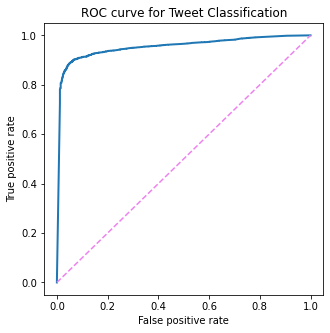

In [279]:
# make the ROC curve plot
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test_nmf)[:,1])

plt.figure(figsize=(5,5))
plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for Tweet Classification');
print("ROC AUC score = ", roc_auc_score(y_test, rf.predict_proba(X_test_nmf)[:,1]))

In [280]:
# function to calc ROC AUC
def quick_test_auc(model, x_train, y_train, x_test, y_test):
    """function calculates ROC AUC
    """
    model.fit(x_train, y_train)
    y_pred_proba = model.predict_proba(x_test)[:,1]

    return roc_auc_score(y_test, y_pred_proba)

# call 'quick_test_auc' and do test n times and take that mean
def quick_test_auc_times(name, model, X_train, y_train, X_test, y_test, n=5):
    """function calls quick_test_auc and prints ROC AUC result
    """
    return print('{} ROC AUC:'.format(name) , 
                 np.mean([quick_test_auc(model, X_train, y_train, X_test, y_test) for j in range(n)]))

In [281]:
# Do the test 5 times and get the average score
quick_test_auc_times('RandFor', rf, X_tr_rs, y_tr_rs, X_test_nmf, y_test)

RandFor ROC AUC: 0.9532674783515043


Model best Recall 1.000 at prob decision threshold >= 0.000
Model best Precision 0.985 at prob decision threshold >= 0.800
Model best F1 0.958 at prob decision threshold >= 0.582
Test AUC: 0.953


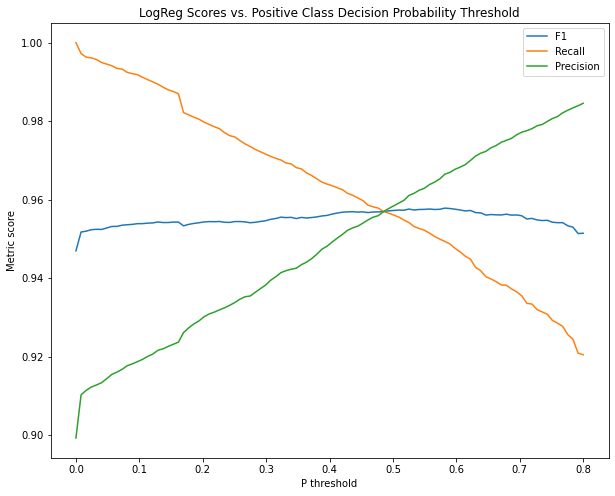

In [282]:
# Threshold Adjustment to Optimize Random Forest 
X_val, y_val = X_test_nmf, y_test # explicitly calling this validation

thresh_ps = np.linspace(0, .8, 100)
model_val_probs = rf.predict_proba(X_val)[:,1] # positive class probs 

f1_scores, rec_scores, prec_scores = [], [], []

for p in thresh_ps:
    model_val_labels = model_val_probs >= p
    f1_scores.append(f1_score(y_val, model_val_labels))
    rec_scores.append(recall_score(y_val, model_val_labels))
    prec_scores.append(precision_score(y_val, model_val_labels))

plt.plot(thresh_ps, f1_scores)
plt.plot(thresh_ps, rec_scores)
plt.plot(thresh_ps, prec_scores)

plt.title('LogReg Scores vs. Positive Class Decision Probability Threshold')
plt.legend(['F1', 'Recall', 'Precision'])
plt.xlabel('P threshold')
plt.ylabel('Metric score')

best_recall_score = np.max(rec_scores)
best_thresh_p = thresh_ps[np.argmax(rec_scores)]

best_prec_score = np.max(prec_scores)
best_thresh_p1 = thresh_ps[np.argmax(prec_scores)]

best_f1_score = np.max(f1_scores)
best_thresh_p2 = thresh_ps[np.argmax(f1_scores)]

print('Model best Recall %.3f at prob decision threshold >= %.3f' 
      % (best_recall_score, best_thresh_p))
print('Model best Precision %.3f at prob decision threshold >= %.3f' 
      % (best_prec_score, best_thresh_p1))
print('Model best F1 %.3f at prob decision threshold >= %.3f' 
      % (best_f1_score, best_thresh_p2))
print('Test AUC: %.3f' % roc_auc_score(y_test, rf.predict_proba(X_test_nmf)[:,1]))

# will choose threshold of 0.533 for interactive calcs on streamlit

In [283]:
# fcn to make confusion matrix for interactive plot
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_pred = (model.predict_proba(X_test_nmf)[:, 1] >= threshold)
    confusion = confusion_matrix(y_test, y_pred)
    plt.figure(dpi=80)
    sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d')
           #xticklabels=['low', 'high'],
           #yticklabels=['low', 'high']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [284]:
# Let's see how our confusion matrix changes with changes to the cutoff! 
from ipywidgets import interactive, FloatSlider

interactive(lambda threshold: make_confusion_matrix(rf, threshold), threshold=(0.0,1.0,0.01))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.01), Output()), _dom_cla…

## Logistic Regression

### Log Reg not as good as RF

In [285]:
# range of LogReg C hyperparameter to tune
C_range = [0.001,0.01,0.1,1,10,100]
cv_score_lst = []

for i in C_range:
    
    # Create a logistic regression model with class weights to balance data
    lr = LogisticRegression(C = i, solver='liblinear', random_state = 55)
    
    cv_score_lst.append([i, np.mean(cross_val_score(lr, X_tr_rs, y_tr_rs, cv=10, scoring='f1'))]) # get cv r-sqr score



In [286]:
# F1 scores
cv_score_lst

[[0.001, 0.6729253470446643],
 [0.01, 0.6729253470446643],
 [0.1, 0.6782079992501652],
 [1, 0.6866378210764598],
 [10, 0.6658866185153404],
 [100, 0.6608429972776351]]

In [287]:
# instantiate LogReg object with best tuning param C
lr = LogisticRegression(C=1, solver='liblinear', random_state = 55)


In [288]:
# Do the test 5 times and get the average score
quick_test_auc_times('LogReg', lr, X_tr_rs, y_tr_rs, X_test_nmf, y_test)

LogReg ROC AUC: 0.6405538099967648


In [289]:
# print the CV accuracy, recall and precision scores on training data
print('Logistic Regression Scoring\n')
print('CV Train accuracy:', cross_val_score(lr, X_tr_rs, y_tr_rs, cv=10, scoring='accuracy').mean())
print('CV Train recall:', cross_val_score(lr, X_tr_rs, y_tr_rs, cv=10, scoring='recall').mean())
print('CV Train Precision:', cross_val_score(lr, X_tr_rs, y_tr_rs, cv=10, scoring='precision').mean())

Logistic Regression Scoring

CV Train accuracy: 0.605720863692758
CV Train recall: 0.8519138255595065
CV Train Precision: 0.5750798355853911


In [290]:
print('CV Train F1 Score:', cross_val_score(lr, X_tr_rs, y_tr_rs, cv=10, scoring='f1').mean())

CV Train F1 Score: 0.6866378210764598
